# Определение возраста по фото

## Исследовательский анализ данных



Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 

В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

Извлечь данные из папки вам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

In [ ]:
# Импортируем библиотеки

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [4]:
# Загрузим labels.csv

labels = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
# Проверим размер labels

print("Размер выборки:", labels.shape[0])
print(labels.head())

Размер выборки: 7591
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [6]:
# Посмотрим татистику по возрасту

print("\nСтатистика по возрасту:")
print(labels['real_age'].describe())


Статистика по возрасту:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


Средний возраст - 31 год. Представлены фото людей возрастом от 1 до 100 лет, что соответствует реальности.

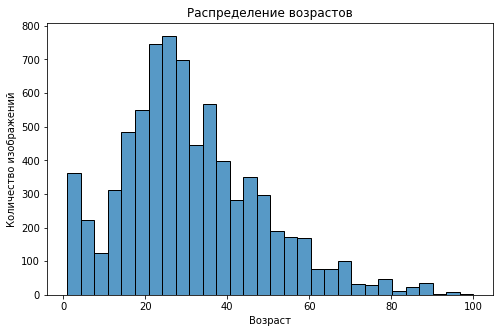

In [7]:
# Построим гистограмму распределения возрастов

plt.figure(figsize=(8, 5))
sns.histplot(labels['real_age'], bins=30, kde=False)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

На гистограмме мы видим дисбаланс классов по возрастам. Больше всего фотографий людей возрастом 20-40 лет, детей и стариков меньше. Думаю на определении возрастов детей и стариков модель будет чаще ошибаться.

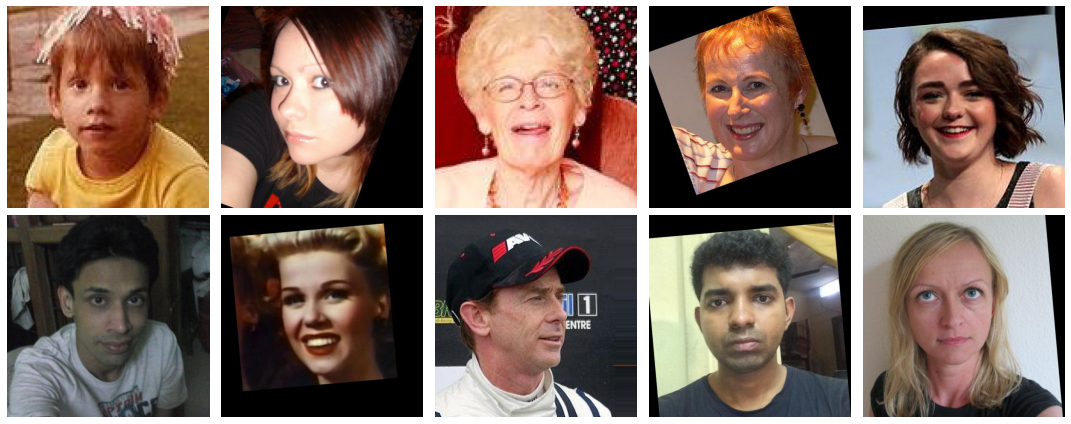

In [8]:
# Выведем 10 картинок

path = '/datasets/faces/final_files'

files = sorted(os.listdir(path))[:10]

plt.figure(figsize=(15, 6))
for i, fname in enumerate(files):
    img = plt.imread(os.path.join(path, fname))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

На примерах фото есть:

- дети, старики и люди среднего возраста
- современные четкие снимки и старые размытые
- разные ракурсы съемки и освещение
- люди разных рас, пола, причесок
- поворот фотографий 

Из-за большого разнообразия фотографий в датасете модели скорее всего будет сложно добиться низкой ошибки.

## Загрузка данных и моделирование

In [ ]:
# Импорт библиотек

from keras.applications.resnet import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_train(path):
    
    """
    Загружает тренировочную часть датасета изображений с метками возраста.

    Параметры
    ----------
    path : str
        Путь к папке с данными. В папке должен быть файл labels.csv
        (с колонками 'file_name' и 'real_age') и подпапка final_files/ с изображениями.

    Возвращает
    -------
    datagen_flow : DirectoryIterator
        Итератор Keras, подающий батчи изображений (224x224) и целевые значения возраста.
        Используется для обучения модели.
    """

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345
        )
    
    return datagen_flow

In [ ]:
def load_test(path):

    """
    Загружает валидационную часть датасета изображений с метками возраста.

    Параметры
    ----------
    path : str
        Путь к папке с данными. В папке должен быть файл labels.csv
        (с колонками 'file_name' и 'real_age') и подпапка final_files/ с изображениями.

    Возвращает
    -------
    datagen_flow : DirectoryIterator
        Итератор Keras, подающий батчи изображений (224x224) и целевые значения возраста.
        Используется для валидации модели во время обучения.
    """

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345
        )
    
    return datagen_flow


In [ ]:
def create_model(input_shape):

    """
    Создаёт и компилирует модель для регрессии возраста на изображениях лиц.

    Архитектура
    -----------
    - Предобученный ResNet50 без верхних слоёв (include_top=False).
    - GlobalAveragePooling2D для преобразования признаков в вектор.
    - Полносвязный слой Dense(256, activation='relu').
    - Полносвязный слой Dense(64, activation='relu').
    - Выходной слой Dense(1, activation='linear') для предсказания возраста.

    Параметры
    ----------
    input_shape : tuple
        Размер входных изображений (высота, ширина, каналы), например (224, 224, 3).

    Возвращает
    -------
    model : keras.Model
        Скомпилированная модель Keras с оптимизатором Adam, функцией потерь MSE
        и метрикой MAE.
    """

    optimizer = Adam(lr=0.0001) 
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
        ) 
    
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

    model.summary()

    return model

In [ ]:
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    """
    Обучает модель на тренировочных данных и оценивает её на валидационных.

    Параметры
    ----------
    model : keras.Model
        Скомпилированная модель Keras.
    train_datagen_flow : DirectoryIterator
        Итератор с тренировочными изображениями и возрастами.
    test_datagen_flow : DirectoryIterator
        Итератор с валидационными изображениями и возрастами.
    batch_size : int, optional
        Размер батча (по умолчанию используется значение из генератора).
    epochs : int, default=10
        Количество эпох обучения.
    steps_per_epoch : int, optional
        Количество шагов за эпоху (если None, берётся из генератора).
    validation_steps : int, optional
        Количество шагов на валидации (если None, берётся из генератора).

    Возвращает
    -------
    model : keras.Model
        Обученная модель Keras.
    """

    model.fit(
        train_datagen_flow,
        validation_data=test_datagen_flow,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size, epochs=epochs, verbose=2, shuffle=True
        ) 
    
    return model

## Выводы модели

In [ ]:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
=================================================================
Total params: 24,128,769
Trainable params: 24,075,649
Non-trainable params: 53,120
_________________________________________________________________
<class 'keras.engine.sequential.Sequential'>
Epoch 1/10 - 80s - loss: 201.9418 - mean_absolute_error: 10.2704 - val_loss: 576.7915 - val_mean_absolute_error: 18.0790
Epoch 2/10 - 48s - loss: 64.0269 - mean_absolute_error: 6.0821 - val_loss: 639.4915 - val_mean_absolute_error: 22.0759
Epoch 3/10 - 48s - loss: 33.9421 - mean_absolute_error: 4.4822 - val_loss: 161.1017 - val_mean_absolute_error: 12.2380
Epoch 4/10 - 48s - loss: 23.0909 - mean_absolute_error: 3.6897 - val_loss: 236.1084 - val_mean_absolute_error: 8.4725
Epoch 5/10 - 48s - loss: 19.1197 - mean_absolute_error: 3.3124 - val_loss: 116.9612 - val_mean_absolute_error: 7.0163
Epoch 6/10 - 48s - loss: 18.0624 - mean_absolute_error: 3.2218 - val_loss: 74.5721 - val_mean_absolute_error: 6.4849
Epoch 7/10 - 48s - loss: 14.6272 - mean_absolute_error: 2.8446 - val_loss: 48.6828 - val_mean_absolute_error: 6.4330
Epoch 8/10 - 48s - loss: 15.0180 - mean_absolute_error: 2.9878 - val_loss: 26.9487 - val_mean_absolute_error: 6.0914
Epoch 9/10 - 48s - loss: 12.9806 - mean_absolute_error: 2.7349 - val_loss: 30.1886 - val_mean_absolute_error: 6.4001
Epoch 10/10 - 48s - loss: 12.2873 - mean_absolute_error: 2.7059 - val_loss: 94.8055 - val_mean_absolute_error: 6.2721
Test MAE: 6.2721

## Вывод

- Train MAE: быстро падает с 10 до 2.7 лет к 10-й эпохе
- Val MAE: стартует очень высоким (18–22 лет), но затем снижается и стабилизируется на уровне 6.2 лет
- Разница между Train MAE и Val MAE: модель учится но, но на валидации ошибается примерно в 2 раза больше чем на трейне
- Скорее всего моджель лучше предсказывает частые возрасты (20-40 лет), а на редких (старики и дети) часто ошибается, что увеличивает MAE
- Первые 8 эпох модель училась хорошо, псоле 8й эпохи улучшения ужже минимальны

- Задача получить МАЕ < 7 выполнена